In [1]:
from tensorflow import keras
from PIL import Image
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
import torch
import random
from torchvision import models, transforms

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
toTensor = transforms.ToTensor()

sample_size = 800
xSub = x_train[:sample_size]
ySub = y_test[:sample_size]

xTensor = toTensor(xSub)
xTensor = xTensor.permute(1, 0, 2).reshape(len(xSub), 1, 28, 28) # shape: (28, sample_size, 28) -->  shape: (sample_size, 1, 28, 28)

In [4]:
margin = 32

model = nn.Sequential(  nn.Flatten(),
                        nn.Linear(28*28,512),
                        nn.ReLU(),
                        nn.Linear(512,256),
                        nn.ReLU(),
                        nn.Linear(256,32),
                        nn.Sigmoid()
                        )

optimizer = optim.SGD( model.parameters() )
criterion = nn.TripletMarginLoss(p=1, # Manhatten Distance
                                 margin=margin
                                 )

In [5]:
def getAPN(a, pos, dMatrix):
    aP = [a]+pos
    neg_i = [i for i in range(len(dMatrix)) if i not in aP ]

    outPut = []

    for p in  pos:
        posDist = dMatrix[a][p]
        
        legal_i = [i for i in neg_i if posDist < dMatrix[a][i] <= posDist+margin] # i = "global" index of the Hash
        
        legal_dist = [dMatrix[a][i] for i in legal_i]
        
        if legal_dist == []: continue
        max_dist = min(legal_dist)

        n = legal_i[ legal_dist.index(max_dist) ]
        outPut.append( (a, p, n) )

    return outPut

In [20]:
from scipy.spatial import distance_matrix

batchSize = 40
for qwe in range(10000):

    for i in list(range(0, len(xSub) , batchSize)):
        start = i
        end = i + batchSize

        xBatch = xTensor[start:end]
        yBatch = ySub[start:end]

        results = model(xBatch)
        results_np = results.detach().numpy()

        dMatrix = distance_matrix(results_np, results_np, p=1)

        APN_list = []

        for label in set(yBatch):
            pos_i_list = [j for j in range(len(yBatch)) if yBatch[j] == label]

            for anchor_i in pos_i_list:
                pos_i = [j for j in pos_i_list if j != anchor_i]

                APN_list += getAPN(anchor_i, pos_i, dMatrix)


            a_list = []
        p_list = []
        n_list = []

        for apn in APN_list:
            a_list.append(results[ apn[0] ])
            p_list.append(results[ apn[1] ])
            n_list.append(results[ apn[2] ])
        
        # === Improve Model ===
        optimizer.zero_grad()

        loss = criterion(torch.stack(a_list),
                        torch.stack(p_list),
                        torch.stack(n_list) )
        
        loss.backward()
        optimizer.step()

        print(qwe ,i, loss)

0 0 tensor(31.9373, grad_fn=<MeanBackward0>)
0 40 tensor(31.9400, grad_fn=<MeanBackward0>)
0 80 tensor(31.9546, grad_fn=<MeanBackward0>)
0 120 tensor(31.9342, grad_fn=<MeanBackward0>)
0 160 tensor(31.9299, grad_fn=<MeanBackward0>)
0 200 tensor(31.9535, grad_fn=<MeanBackward0>)
0 240 tensor(31.9550, grad_fn=<MeanBackward0>)
0 280 tensor(31.9290, grad_fn=<MeanBackward0>)
0 320 tensor(31.9541, grad_fn=<MeanBackward0>)
0 360 tensor(31.9568, grad_fn=<MeanBackward0>)
0 400 tensor(31.9565, grad_fn=<MeanBackward0>)
0 440 tensor(31.9389, grad_fn=<MeanBackward0>)
0 480 tensor(31.9264, grad_fn=<MeanBackward0>)
0 520 tensor(31.9342, grad_fn=<MeanBackward0>)
0 560 tensor(31.9432, grad_fn=<MeanBackward0>)
0 600 tensor(31.9333, grad_fn=<MeanBackward0>)
0 640 tensor(31.9463, grad_fn=<MeanBackward0>)
0 680 tensor(31.9445, grad_fn=<MeanBackward0>)
0 720 tensor(31.9434, grad_fn=<MeanBackward0>)
0 760 tensor(31.9624, grad_fn=<MeanBackward0>)
1 0 tensor(31.9372, grad_fn=<MeanBackward0>)
1 40 tensor(31.9400

KeyboardInterrupt: 

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Step 1: Perform K-Means Clustering
def kmeans_clustering(hash_codes, n_clusters=10, n_init=10, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=random_state)
    clusters = kmeans.fit_predict(hash_codes)
    return clusters

# Step 2: Build the label-cluster matrix
def build_label_cluster_matrix(clusters, true_labels, n_clusters=10):
    # Initialize a matrix to count label-cluster relationships  
    label_cluster_matrix = np.zeros((10, n_clusters), dtype=int)
    
    for label, cluster in zip(true_labels, clusters):
        label_cluster_matrix[label][cluster] += 1
    
    return label_cluster_matrix

# Step 3: Visualize the result as a heatmap
def plot_heatmap(label_cluster_matrix):
    plt.figure(figsize=(10, 6))
    sns.heatmap(label_cluster_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title("Label Distribution Across Clusters")
    plt.xlabel("Clusters")
    plt.ylabel("True Labels")
    plt.show()


def easyHeatmap(hashCodes, labels):
    raw_clusters = kmeans_clustering(hashCodes, n_clusters=10)

    raw_label_cluster_matrix = build_label_cluster_matrix(raw_clusters, labels)

    plot_heatmap(raw_label_cluster_matrix)

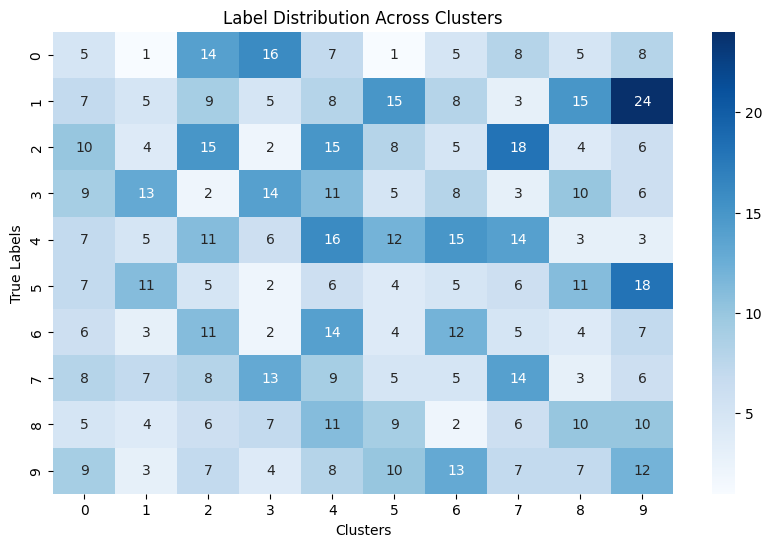

In [21]:
easyHeatmap(model(xTensor).detach().numpy(), ySub)